In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
from pathlib import Path
from collections import Counter

from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import dill
import pandas as pd
import polars as pl
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.model_selection import GroupKFold

import lightgbm as lgb

import pytorch_lightning as L
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from tasks.data.dataset.mappers import EntityEncoder
from tasks.jobs import Splitter

In [3]:
from otto_utils import *
from otto_features import *
from otto_candidates_covisit import *
from otto_lgbm_utils import *
from otto_implicit import *

In [4]:
# live plot
from livelossplot import PlotLosses
plotlosses = PlotLosses()

In [5]:
from gensim.models.callbacks import CallbackAny2Vec
import os
import math
import sys
from datetime import datetime
import psutil  
import numpy as np

def sys_stats():
    pid = os.getpid()
    ps = psutil.Process(pid)
    memory_usage = ps.memory_info()[0] / 2. ** 30
    return f'{datetime.now()}  memory usage GB:' + str(np.round(memory_usage, 2))

class w2vcallback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''
  
    def __init__(self):
        self.epoch = 0
        self.loss_last = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        # define your own calculation of the loss
        loss_now = loss - self.loss_last
        self.loss_last = loss
        self.epoch += 1
        
        print(f'{sys_stats()} Loss after epoch {self.epoch}: {loss_now}')   
        plotlosses.update({    
           'loss': loss_now, ### / (epoch + 2.),
        })
        plotlosses.send()

In [6]:
from gensim.models import Word2Vec

# Valid

In [8]:
# load
val_df_train = pl.read_parquet(VALIDATION_PATH / "train.parquet", use_pyarrow=True)
val_df_valid_input = pl.read_parquet(VALIDATION_PATH / "valid.parquet", use_pyarrow=True)
val_df_valid_targets = pl.read_parquet(VALIDATION_PATH / "test_labels.parquet", use_pyarrow=True)

In [9]:
df = pl.concat([val_df_train, val_df_valid_input]).unique().sort(["session", "ts"])

In [10]:
sentences = (
    df
    .groupby('session').agg([
        pl.col('aid').alias('sentence')
    ])["sentence"].to_list()
)

In [13]:
%env PYTHONHASHSEED=1
import hashlib
def hashf(s):
    return int(hashlib.md5(str(s).encode()).hexdigest(), 32)


env: PYTHONHASHSEED=1


In [14]:
num_of_vecs = 32
min_count_events_per_session = 1
num_of_epochs = 30
init_lr = 1e-2

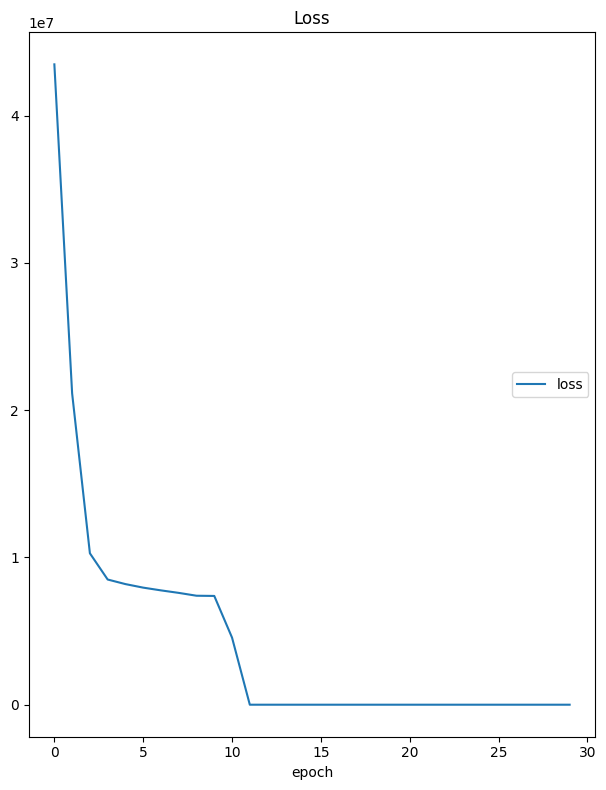

Loss
	loss             	 (min:    0.000, max: 43475276.000, cur:    0.000)


In [15]:
w2vec = Word2Vec(
    sentences, vector_size=num_of_vecs, min_count=min_count_events_per_session, 
    workers=40, 
    sg = 1, 
    negative = 20, ns_exponent = 0.2, window=10, 
    alpha = init_lr, min_alpha=1e-4, epochs = num_of_epochs,
    seed = 3, hashfxn = hashf,
    compute_loss=True, callbacks=[w2vcallback()])

In [16]:
w2vec.wv.vectors.shape

(1825636, 32)

In [17]:
w2vec.save("__valid__word2vec_window=10_negative=20.w2v")

# Test

In [7]:
df_train = pl.read_parquet(TRAIN_PROCESSED, use_pyarrow=True)
df_test = pl.read_parquet(TEST_PROCESSED, use_pyarrow=True)

In [8]:
df = pl.concat([df_train, df_train]).unique().sort(["session", "ts"])

In [9]:
sentences = (
    df
    .groupby('session').agg([
        pl.col('aid').alias('sentence')
    ])["sentence"].to_list()
)

In [10]:
%env PYTHONHASHSEED=1
import hashlib
def hashf(s):
    return int(hashlib.md5(str(s).encode()).hexdigest(), 32)


env: PYTHONHASHSEED=1


In [11]:
num_of_vecs = 32
min_count_events_per_session = 1
num_of_epochs = 30
init_lr = 1e-2

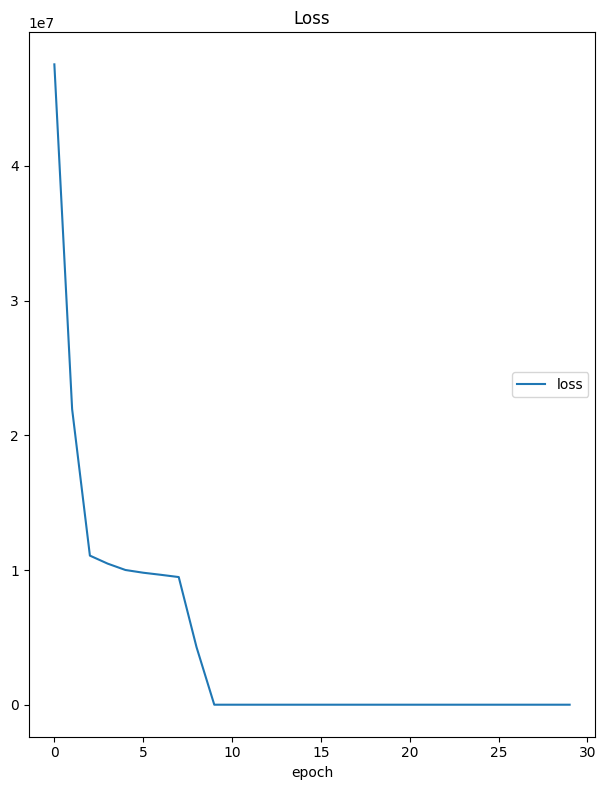

Loss
	loss             	 (min:    0.000, max: 47539384.000, cur:    0.000)


In [12]:
w2vec = Word2Vec(
    sentences, vector_size=num_of_vecs, min_count=min_count_events_per_session, 
    workers=44, 
    sg = 1, 
    negative = 20, ns_exponent = 0.2, window=10, 
    alpha = init_lr, min_alpha=1e-4, epochs = num_of_epochs,
    seed = 3, hashfxn = hashf,
    compute_loss=True, callbacks=[w2vcallback()])

In [13]:
w2vec.wv.vectors.shape

(1855603, 32)

In [14]:
w2vec.save("__subm__word2vec_window=10_negative=20.w2v")